In [2]:
# imports de bibliotecas

import numpy as np
import mne
from scipy.signal import welch
import matplotlib.pyplot as plt

In [3]:
#  definição do info (MNE)

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [4]:
# aula -> 99750 até 296500 (ga1) | 5250 até 119250 (ga2) [1243 segundos]
# teste -> 126750 até 158000 (ga2) [125 segundos]
tf = [
  '../dataset/OpenBCI-RAW-2023-11-28_15-44-34.txt', # REMOVE:(15-16) (60-67) (111-114)
  '../dataset/OpenBCI-RAW-2023-11-28_15-50-35.txt', # REMOVE:(14-16) (96-99)
  '../dataset/OpenBCI-RAW-2023-11-28_15-53-44.txt'  # REMOVE:(00-37)
  ]

tf_ob = [np.loadtxt(txt, delimiter=',', skiprows=5, usecols=range(1, 9)) for txt in tf]

data_tf = np.concatenate((
  tf_ob[0][17*sfreq:59*sfreq,:], tf_ob[0][68*sfreq:110*sfreq,:], tf_ob[0][115*sfreq:,:], # 17-59, 68-110, 115-248(final) = 217
  tf_ob[1][17*sfreq:95*sfreq,:], tf_ob[1][100*sfreq:,:], # 17-95, 100-143(final) = 121
  tf_ob[2][38*sfreq:,:] #38-318(final) = 280
))


x_tf = mne.io.RawArray(data_tf.T, info)
x_tf.set_eeg_reference(ref_channels='average') # CAR
X = {
    'tf':  x_tf,
}

Creating RawArray with float64 data, n_channels=8, n_times=154980
    Range : 0 ... 154979 =      0.000 ...   619.916 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [5]:
# filtragem de todos os dados

for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband e

In [6]:
import sys

sr = 250            # taxa de amostragem
jump = 5            # 5 segundos de buffer
size = sr * jump    # quantidade de pontos avaliados

# Definir os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

total_pc = {}
data_names = ('tf')
for k, data in enumerate(X.values()):
    results = [0, 0, 0, 0]
    for i in range(0, len(data)-1, sr):
        # Isso faz parte da TAREFA 1 explicada logo abaixo.
        # Para aplicar o set_eeg_reference, é necessário que os dados
        # estejam no objeto RawArray, que é o objeto que contém o método.
        # O slice deve ser obtido diretamente do objeto MNE, tendo que 
        # nesse caso modificar todos o laço de controle.
        cut = data.get_data(start=i, stop=i+size)
        # Número de pontos por segmento
        nperseg = 128
        # Quantidade de sobreposição entre segmentos
        noverlap = nperseg // 2
        
        freqs, psd = welch(cut, fs=sr, nperseg=nperseg, noverlap=noverlap)
        
        # TAREFA 1 (APLICANDO UM FILTRO ESPACIAL NO DADOS)
        # realizando a média dos 8 eletrodos
        # no caso do trabalho, analizar os canais separadamente.
        #   Para isso, vamos aplicar o filtro espacial, no qual
        #   podemos utilizar algoritmos específicos para a análise
        #   de EEG utilizando o CAR (Common Average Reference).
        #   Na biblioteca MNE existe o método set_eeg_reference, que
        #       pode ser utilizado para aplicar o filtro espacial.
        X = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        # Calcular a potência em cada banda de frequência por meio da integração da PSD
        bands = [np.sum(X[theta_idxs]), np.sum(X[alpha_idxs]), np.sum(X[beta_idxs]), np.sum(X[gamma_idxs])]
        # calculando a pontuação de cada banda para mostrar a porcentagem futura
        results[np.argmax(bands)] += 1

    total = sum(results)
    percentages = [round((count/total) * 100, 2) for count in results]
    print(data.__str__())
    total_pc[data_names[k]] = percentages

print(total_pc)

<RawArray | 8 x 154980 (619.9 s), ~9.5 MB, data loaded>
{'t': [40.97, 0.0, 4.19, 54.84]}


In [7]:
# file = './data_filtered.fif'
# file = '../dataset/filtered/tf.fif'

# raw = mne.io.read_raw_fif(file)
# # data =  raw.get_data()

# raw.compute_psd(fmax=120).plot(picks="data", exclude="bads", amplitude=False)
# raw.plot(duration=5, n_channels=30)


In [8]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [6., 4.]

def plot_bar(x):
    colors = ('orange', 'green', 'blue', 'purple')
    bars = plt.bar(('theta', 'alpha', 'beta', 'gamma'), x, color=colors)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    plt.title('Porcentagem da potência em cada banda de frequência')
    plt.xlabel('Banda de Frequência')
    plt.ylabel('Porcentagem durante a atividade')

    # Exibir o gráfico
    plt.show()

Teste final


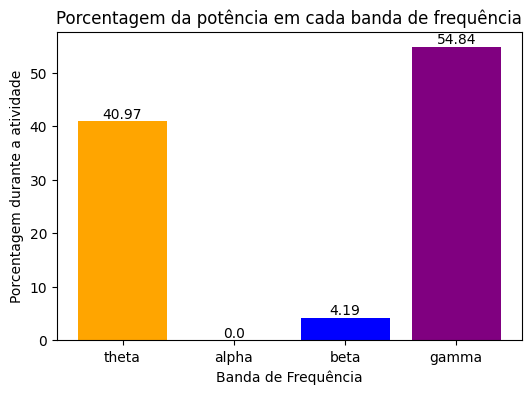

In [9]:
print('Teste final')
plot_bar(total_pc['t'])

In [10]:
def print_graphs(X):
    for i in range(X.shape[1]):
        plt.plot(X[:,i])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(X.shape[1]):
        plt.psd(X[:,i], Fs=250)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(X.shape[1]):
        plt.specgram(X[i,:], Fs=250)
    plt.title('Espectrograma')
    plt.show()

(1500, 8)


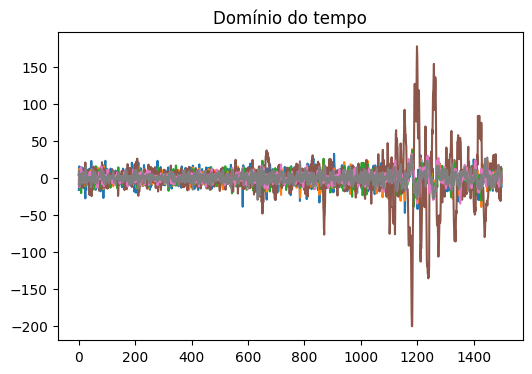

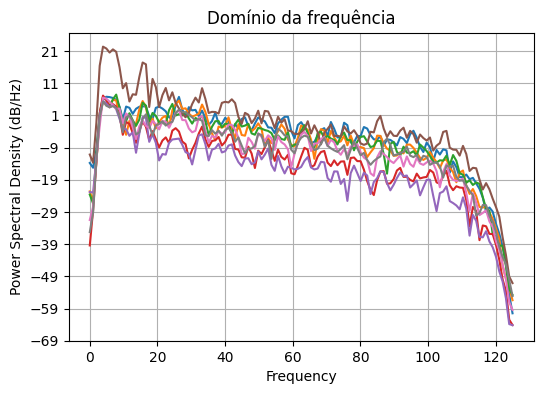

/tmp/ipykernel_7701/291471394.py:13: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=8).
  plt.specgram(X[i,:], Fs=250)


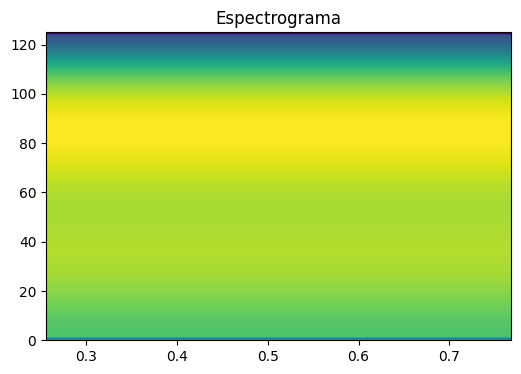

In [11]:
# data = x_tf.get_data(tmin=min)
# data = data.transpose() 
# print(data.shape)
# print_graphs(data)

# @ MOMENTO EM QUE O BETA ESTÁ ALTO: 4:16 - 4:22 = 256 - 262
min = 256
max = 262
data = x_tf.get_data(tmin=min,tmax=max)
data = data.transpose() 
print(data.shape)
print_graphs(data)